<a href="https://colab.research.google.com/github/RobelDawit/Adverserial-Attack-defense-algorithm/blob/main/UAV_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load the dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bulentsiyah/semantic-drone-dataset")

print("Path to dataset files:", path)

!cp -r /root/.cache/kagglehub/datasets/bulentsiyah/semantic-drone-dataset/versions/6 /content/semantic-drone-dataset

100%|██████████| 3.89G/3.89G [00:50<00:00, 82.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bulentsiyah/semantic-drone-dataset/versions/6


In [ ]:
!cp -r /root/.cache/kagglehub/datasets/bulentsiyah/semantic-drone-dataset/versions/6 /content/semantic-drone-dataset

In [ ]:
import os

directory_path = "/content/semantic-drone-dataset"

os.listdir(directory_path)

['class_dict_seg.csv', 'dataset', '6', 'RGB_color_image_masks']

In [ ]:
images = "/content/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images"
masks = "/content/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks"

#Store the color code and vizualize as a dataframe

In [ ]:
import pandas as pd

class_dict = pd.read_csv("/content/semantic-drone-dataset/class_dict_seg.csv")
class_dict.head(25)

name    r    g    b
0     unlabeled    0    0    0
1    paved-area  128   64  128
2          dirt  130   76    0
3         grass    0  102    0
4        gravel  112  103   87
5         water   28   42  168
6         rocks   48   41   30
7          pool    0   50   89
8    vegetation  107  142   35
9          roof   70   70   70
10         wall  102  102  156
11       window  254  228   12
12         door  254  148   12
13        fence  190  153  153
14   fence-pole  153  153  153
15       person  255   22   96
16          dog  102   51    0
17          car    9  143  150
18      bicycle  119   11   32
19         tree   51   51    0
20    bald-tree  190  250  190
21    ar-marker  112  150  146
22     obstacle    2  135  115
23  conflicting  255    0    0

#Create a function to vizualize images and segmentation masks

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from PIL import Image

def vizualize_images(imagepath, mask_path):
  image_list = sorted(os.listdir(imagepath))
  mask_list = sorted(os.listdir(mask_path))
  image_name = random.choice(image_list)
  mask_name = image_name.split(".")[0] + ".png"
  image = Image.open(os.path.join(imagepath, image_name))
  mask = Image.open(os.path.join(mask_path, mask_name))
  print(f'the image has the shape of {np.array(image).shape}')
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.axis("off")
  plt.title("Image")
  plt.subplot(1, 2, 2)
  plt.imshow(mask)
  plt.axis("off")
  plt.title("Mask")
  plt.show()

the image has the shape of (4000, 6000, 3)


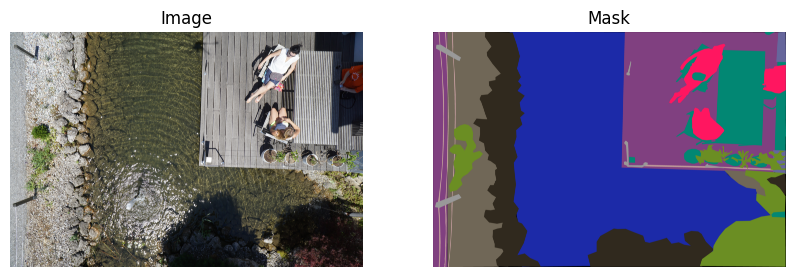

In [ ]:
vizualize_images(images, masks)

#Vizualize labels

In [ ]:
label_path = '/content/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic'

(4000, 6000)


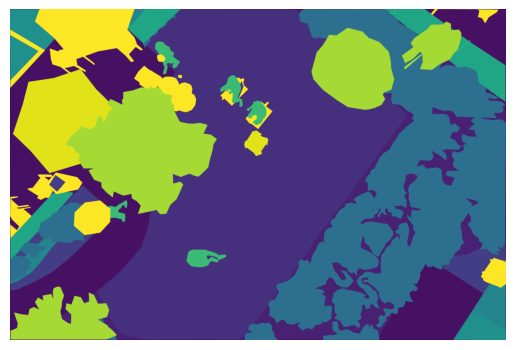

In [ ]:
label_one = sorted(os.listdir(label_path))[32]
label_one_name = label_one.split(".")[0] + ".png"
label_one_path = os.path.join(label_path, label_one)
label_one_path

import cv2
import numpy as np

label_one = Image.open(label_one_path)
read_label = np.array(label_one)
print(read_label.shape)
unique = np.unique(read_label)
unique
plt.imshow(label_one)
plt.axis("off")
plt.show()

The labels for this dataset have 24 classes as follows

In [ ]:
class_dict.name

0       unlabeled
1      paved-area
2            dirt
3           grass
4          gravel
5           water
6           rocks
7            pool
8      vegetation
9            roof
10           wall
11         window
12           door
13          fence
14     fence-pole
15         person
16            dog
17            car
18        bicycle
19           tree
20      bald-tree
21      ar-marker
22       obstacle
23    conflicting
Name: name, dtype: object

#preprocessing

The primary goal here is to reduce dimensionality of the images for more efficient training:

1. Reduce the number of classes from 25 to 8 by clustering based on similarity.

2. Reduce the size of the images to (224,224,3) for efficient loading and training. the masks will be resized to (224,224)

3. If initial training does not go well. Augmenting the data with new images (Horizontal flips, vertical flips, rotations)

In [ ]:
#spit images into train and test folders

label_dir = '/content/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic'
image_dir = '/content/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images'
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))])
label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))])

##Resizing the images and masks to 224 by 224 for efficiency,
Will also be relabelling masks with coarse labels

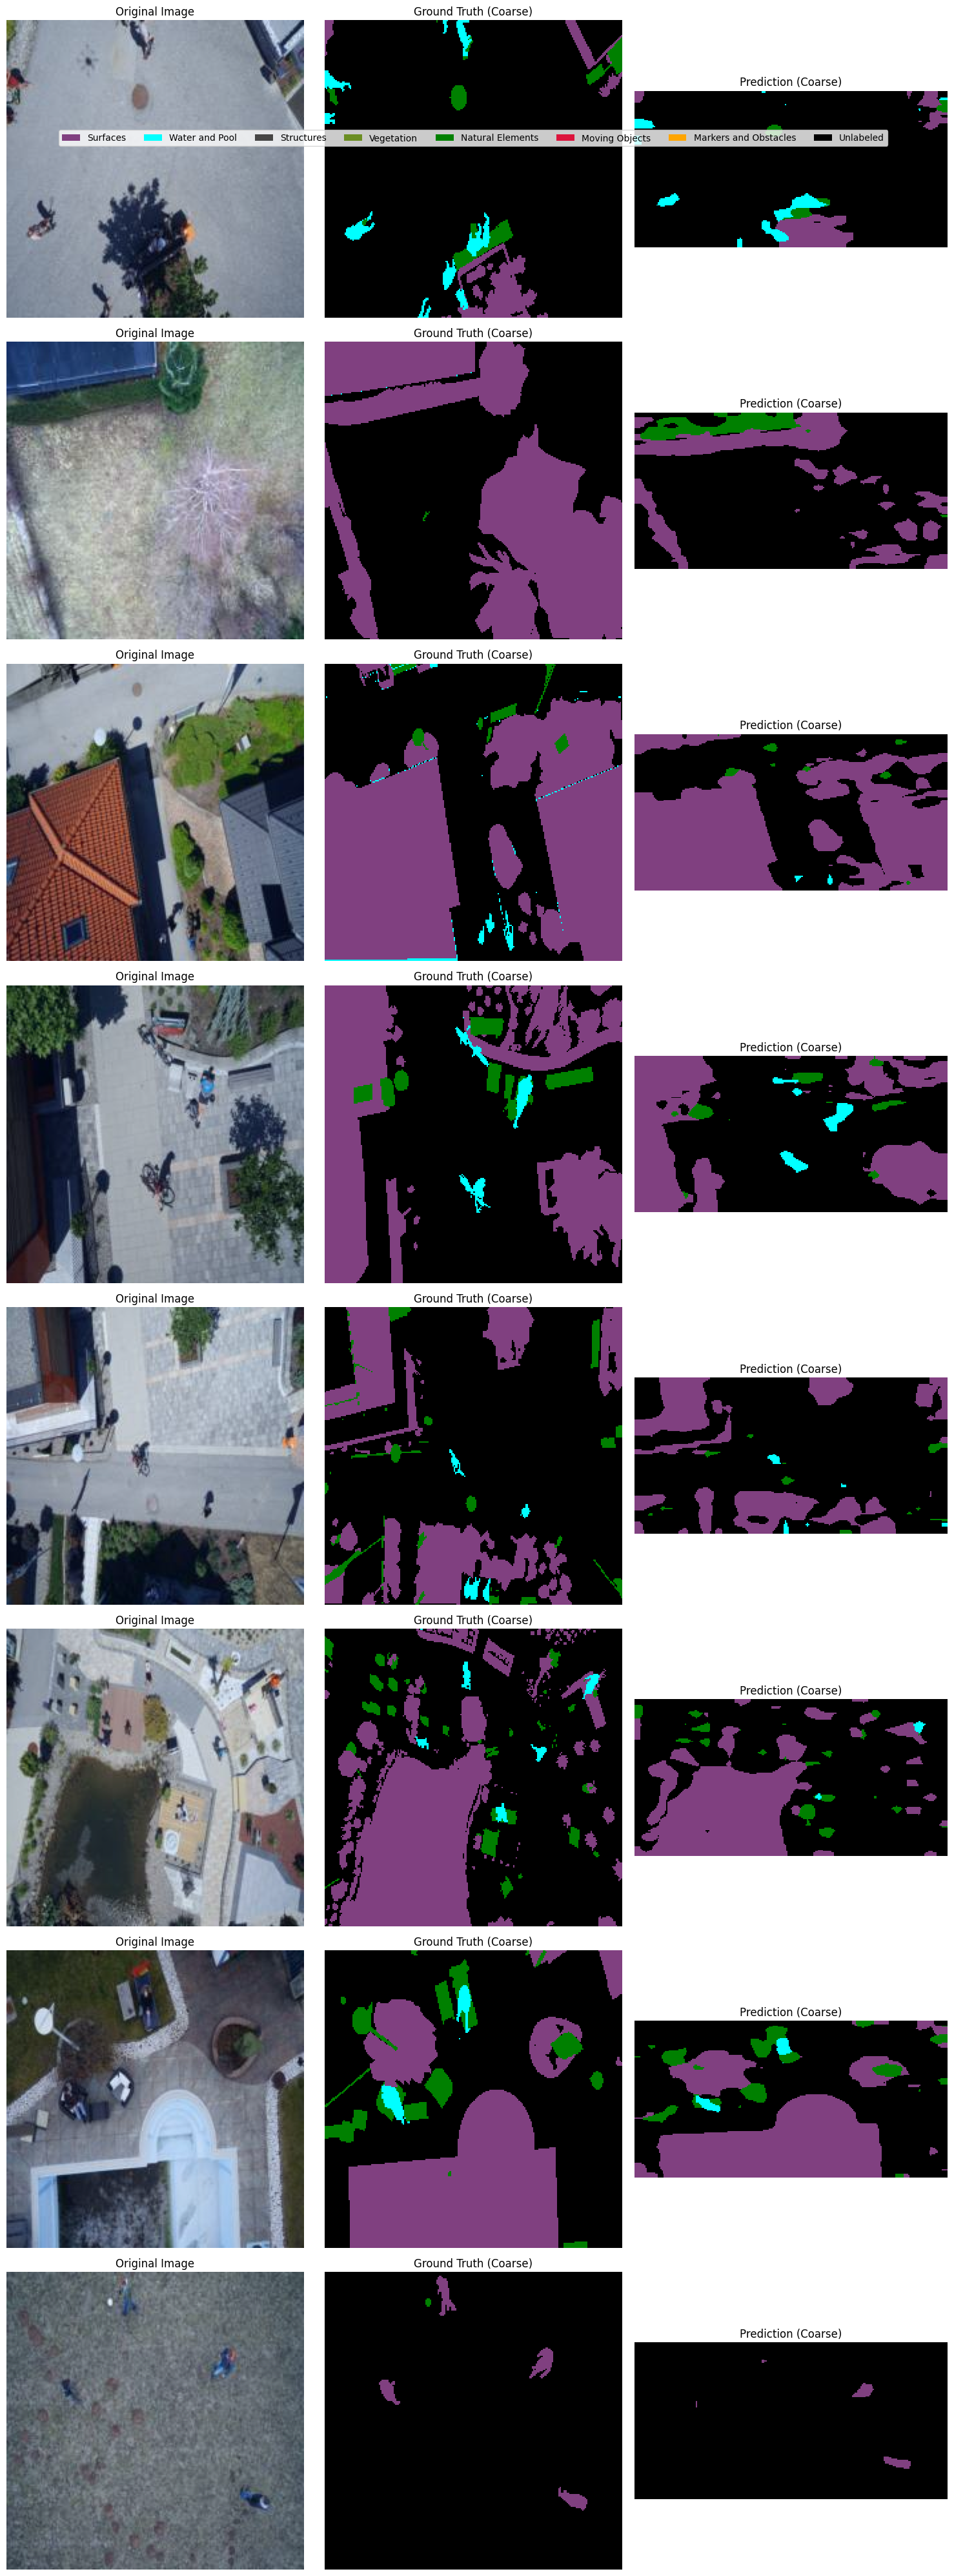

In [ ]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms

# Function to resize images and masks
def resize_image_and_mask(image_path, mask_path, target_size=(224, 224)):
    """
    Resizes both images and masks to the target size.

    Args:
        image_path (str): Path to the image file.
        mask_path (str): Path to the mask file.
        target_size (tuple): Target size for resizing (height, width).

    Returns:
        Tuple of resized image (PIL.Image) and mask (numpy array).
    """
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")  # Grayscale mask

    # Resize using torchvision transforms
    image_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])
    mask_transform = transforms.Compose([
        transforms.Resize(target_size, interpolation=Image.NEAREST)
    ])

    resized_image = image_transform(image)  # Convert to tensor
    resized_mask = mask_transform(mask)  # Keeps mask as PIL.Image
    return resized_image, np.array(resized_mask)

# Function to relabel masks
def change_mask(mask, coarse_labels):
    """
    Relabels the mask using the coarse_labels dictionary.

    Args:
        mask (np.ndarray): Original mask array.
        coarse_labels (dict): Mapping of fine labels to coarse labels.

    Returns:
        np.ndarray: Relabeled mask.
    """
    new_mask = np.zeros_like(mask)
    for i in sorted(coarse_labels):
        new_mask[mask == i] = coarse_labels[i]
    return new_mask

# Paths
label_dir = '/content/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic'
image_dir = '/content/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images'

output_image_dir = "/content/processed_images"
output_label_dir = "/content/processed_masks"

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

# Coarse labels dictionary
coarse_labels = {
    1: 0, 2: 0, 3: 0, 4: 0,  # Grouped as 'Surfaces'
    5: 1, 7: 1,              # Grouped as 'Water and Pool'
    9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2,  # Grouped as 'Structures'
    8: 3, 19: 3, 20: 3,      # Grouped as 'Vegetation'
    6: 4,                    # 'Natural Elements'
    15: 5, 16: 5, 17: 5, 18: 5,  # 'Moving Objects'
    21: 6, 22: 6, 23: 6,     # 'Markers and Obstacles'
    0: 7,                    # 'Unlabeled'
}

# Process all images and masks
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))])
label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))])

for img_path, lbl_path in zip(image_files, label_files):
    # Resize image and mask
    resized_image, resized_mask = resize_image_and_mask(img_path, lbl_path)

    # Relabel the mask
    relabeled_mask = change_mask(resized_mask, coarse_labels)

    # Save resized image and relabeled mask
    output_img_path = os.path.join(output_image_dir, os.path.basename(img_path))
    output_lbl_path = os.path.join(output_label_dir, os.path.basename(lbl_path))

    transforms.ToPILImage()(resized_image).save(output_img_path)
    Image.fromarray(relabeled_mask.astype(np.uint8)).save(output_lbl_path)

    print(f"Processed and saved: {output_img_path}, {output_lbl_path}")

##Save the rezised and relabelled images and masks to google drive

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Specify the Google Drive directory for saving the data
google_drive_dir = "/content/drive/My Drive/segmentation_data"
output_image_dir = os.path.join(google_drive_dir, "images")
output_label_dir = os.path.join(google_drive_dir, "masks")

# Create directories in Google Drive if they don't exist
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

Mounted at /content/drive


In [ ]:
for img_path, lbl_path in zip(image_files, label_files):
    # Resize image and mask
    resized_image, resized_mask = resize_image_and_mask(img_path, lbl_path)

    # Relabel the mask
    relabeled_mask = change_mask(resized_mask, coarse_labels)

    # Save resized image and relabeled mask in Google Drive
    output_img_path = os.path.join(output_image_dir, os.path.basename(img_path))
    output_lbl_path = os.path.join(output_label_dir, os.path.basename(lbl_path))

    transforms.ToPILImage()(resized_image).save(output_img_path)
    Image.fromarray(relabeled_mask.astype(np.uint8)).save(output_lbl_path)

    print(f"Saved to Google Drive: {output_img_path}, {output_lbl_path}")

Saved to Google Drive: /content/drive/My Drive/segmentation_data/images/000.jpg, /content/drive/My Drive/segmentation_data/masks/000.png
Saved to Google Drive: /content/drive/My Drive/segmentation_data/images/001.jpg, /content/drive/My Drive/segmentation_data/masks/001.png
Saved to Google Drive: /content/drive/My Drive/segmentation_data/images/002.jpg, /content/drive/My Drive/segmentation_data/masks/002.png
Saved to Google Drive: /content/drive/My Drive/segmentation_data/images/003.jpg, /content/drive/My Drive/segmentation_data/masks/003.png
Saved to Google Drive: /content/drive/My Drive/segmentation_data/images/004.jpg, /content/drive/My Drive/segmentation_data/masks/004.png
Saved to Google Drive: /content/drive/My Drive/segmentation_data/images/005.jpg, /content/drive/My Drive/segmentation_data/masks/005.png
Saved to Google Drive: /content/drive/My Drive/segmentation_data/images/006.jpg, /content/drive/My Drive/segmentation_data/masks/006.png
Saved to Google Drive: /content/drive/My 

# write code for the segmentation model

1. we'll start with a CNN model (baseline)
2. we'll try a pretrained model
3. we'll augment the images for better results

###reload data

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

data_dir = "/content/drive/My Drive/segmentation_data"

Mounted at /content/drive


In [ ]:
import os
from glob import glob
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, root_dir, dataset_type="clean", transform=None):
        """
        Custom Cityscapes Dataset.
        - root_dir: Root directory of the dataset containing images and labels.
        - dataset_type: Either "clean", "adversarial", or "combined".
        - transform: Transformations to apply to images (labels remain untransformed).
        """
        self.root_dir = root_dir
        self.transform = transform

        # Define subdirectories for images and labels based on dataset_type
        if dataset_type == "clean":
            self.image_dir = os.path.join(root_dir, "images")
        elif dataset_type == "adversarial":
            self.image_dir = os.path.join(root_dir, "Adversarial Images")
        elif dataset_type == "combined":
            # Combine original and adversarial images
            clean_images = sorted(glob(os.path.join(root_dir, "images", "*")))
            adversarial_images = sorted(glob(os.path.join(root_dir, "Adversarial Images", "*")))
            self.image_paths = clean_images + adversarial_images
        else:
            raise ValueError(f"Unknown dataset_type: {dataset_type}. Use 'clean', 'adversarial', or 'combined'.")

        if dataset_type != "combined":
            self.image_paths = sorted(glob(os.path.join(self.image_dir, "*")))

        self.label_dir = os.path.join(root_dir, "masks")  # Labels directory is shared
        self.label_paths = sorted(glob(os.path.join(self.label_dir, "*")))

        # Ensure correspondence between images and labels
        assert len(self.image_paths) == len(self.label_paths), (
            f"Mismatch between images ({len(self.image_paths)}) and labels ({len(self.label_paths)})"
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image and label
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        # Load image and label
        image = Image.open(image_path).convert("RGB")  # Load as RGB
        label = Image.open(label_path)  # Labels are grayscale

        # Apply transformation to the image only
        if self.transform:
            image = self.transform(image)

        # Convert label to a tensor without transformation
        label = torch.tensor(np.array(label), dtype=torch.long)

        return image, label


In [ ]:
import os

len(os.listdir('/content/drive/MyDrive/segmentation_data/images'))

400

In [ ]:
import os
from PIL import Image
from torchvision import transforms
import random

# Paths to original images and masks
original_image_dir = '/content/drive/MyDrive/segmentation_data/images'
original_mask_dir = '/content/drive/MyDrive/segmentation_data/masks'

# Paths to augmented images and masks
augmented_image_dir = '/content/drive/MyDrive/segmentation_data_augmented/images'
augmented_mask_dir = '/content/drive/MyDrive/segmentation_data_augmented/masks'

# Create directories if they don't exist
os.makedirs(augmented_image_dir, exist_ok=True)
os.makedirs(augmented_mask_dir, exist_ok=True)

# Augmentation transformations
augmentations = [
    transforms.RandomHorizontalFlip(p=1.0),  # Horizontal Flip
    transforms.RandomVerticalFlip(p=1.0),    # Vertical Flip
    transforms.RandomRotation(degrees=45),   # Rotate by 45 degrees
    transforms.RandomRotation(degrees=90),   # Rotate by 90 degrees
]

# Process and save augmented images and masks
image_files = sorted(os.listdir(original_image_dir))
mask_files = sorted(os.listdir(original_mask_dir))

for img_file, mask_file in zip(image_files, mask_files):
    # Paths to the original image and mask
    img_path = os.path.join(original_image_dir, img_file)
    mask_path = os.path.join(original_mask_dir, mask_file)

    # Load image and mask
    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path)

    # Save original image and mask
    image.save(os.path.join(augmented_image_dir, img_file))
    mask.save(os.path.join(augmented_mask_dir, mask_file))

    # Apply each augmentation and save
    for i, augmentation in enumerate(augmentations):
        # Set the same random seed for consistent transformations
        seed = random.randint(0, 10000)
        random.seed(seed)
        augmented_image = augmentation(image)

        random.seed(seed)
        augmented_mask = augmentation(mask)

        # Generate new filenames for augmented data
        new_img_file = f"{img_file.split('.')[0]}_aug{i}.jpg"
        new_mask_file = f"{mask_file.split('.')[0]}_aug{i}.png"

        # Save augmented image and mask
        augmented_image.save(os.path.join(augmented_image_dir, new_img_file))
        augmented_mask.save(os.path.join(augmented_mask_dir, new_mask_file))

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# Root directory containing the dataset folders
root_dir = '/content/drive/MyDrive/segmentation_data'

# Transformation for datasets
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load datasets
train_dataset = CustomDataset(root_dir=root_dir, dataset_type="combined", transform=transform)
clean_dataset = CustomDataset(root_dir=root_dir, dataset_type="clean", transform=transform)

# Split the clean dataset into validation and unused parts (20% for validation)
val_size = int(0.20 * len(clean_dataset))
unused_size = len(clean_dataset) - val_size
val_dataset, _ = random_split(clean_dataset, [val_size, unused_size])

# Log dataset sizes for debugging
print(f"Training dataset size (combined): {len(train_dataset)}")
print(f"Validation dataset size (clean): {len(val_dataset)}")

# DataLoaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

# Log DataLoader sizes
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")


Training dataset size (combined): 400
Validation dataset size (clean): 80
Number of training batches: 50
Number of validation batches: 10


In [ ]:
len(train_loader)

40

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes=[1, 2, 3, 6]):
        super(PyramidPooling, self).__init__()
        self.pools = nn.ModuleList([
            nn.AdaptiveAvgPool2d(output_size=size) for size in pool_sizes
        ])
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, in_channels // len(pool_sizes), kernel_size=1, bias=False) for _ in pool_sizes
        ])
        out_channels = in_channels + (in_channels // len(pool_sizes)) * len(pool_sizes)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        size = x.shape[2:]
        out = [x]
        for pool, conv in zip(self.pools, self.convs):
            pooled = pool(x)
            conv_out = conv(pooled)
            out.append(F.interpolate(conv_out, size=size, mode='bilinear', align_corners=True))
        out = torch.cat(out, dim=1)
        return self.relu(self.bn(out))


class CascadeFeatureFusion(nn.Module):
    """CFF Unit"""
    def __init__(self, low_channels, high_channels, out_channels, n_classes):
        super(CascadeFeatureFusion, self).__init__()
        self.conv_low = nn.Sequential(
            nn.Conv2d(low_channels, out_channels, kernel_size=3, padding=2, dilation=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.conv_high = nn.Sequential(
            nn.Conv2d(high_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.conv_low_cls = nn.Conv2d(out_channels, n_classes, kernel_size=1, bias=False)

    def forward(self, x_low, x_high):
        x_low = F.interpolate(x_low, size=x_high.shape[2:], mode='bilinear', align_corners=True)
        x_low = self.conv_low(x_low)
        x_high = self.conv_high(x_high)
        x = F.relu(x_low + x_high, inplace=True)
        x_low_cls = self.conv_low_cls(x_low)
        return x, x_low_cls


class SemanticSegmentationModel(nn.Module):
    def __init__(self, n_classes=8):
        super(SemanticSegmentationModel, self).__init__()
        resnet = resnet50(weights='IMAGENET1K_V1')
        self.initial_layers = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool
        )
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        self.pyramid_pooling = PyramidPooling(2048)

        self.cff_24 = CascadeFeatureFusion(low_channels=4096, high_channels=1024, out_channels=512, n_classes=n_classes)
        self.cff_12 = CascadeFeatureFusion(low_channels=512, high_channels=512, out_channels=128, n_classes=n_classes)

        self.classifier = nn.Conv2d(128, n_classes, kernel_size=1)

    def forward(self, x):
        x = self.initial_layers(x)
        c1 = self.layer1(x)
        c2 = self.layer2(c1)
        c3 = self.layer3(c2)
        c4 = self.layer4(c3)

        # Pass through PyramidPooling
        c4 = self.pyramid_pooling(c4)

        # Feature fusion
        c3_c4, aux_c3_c4 = self.cff_24(c4, c3)  # c3: 1024 channels, c4: 4096 channels
        c1_c2_c3, aux_c1_c2 = self.cff_12(c3_c4, c2)  # c3_c4: 512 channels, c2: 512 channels

        out = self.classifier(c1_c2_c3)

        # Upsample to match original input size
        out = F.interpolate(out, size=(224, 224), mode='bilinear', align_corners=False)
        aux_c3_c4 = F.interpolate(aux_c3_c4, size=(224, 224), mode='bilinear', align_corners=False)
        aux_c1_c2 = F.interpolate(aux_c1_c2, size=(224, 224), mode='bilinear', align_corners=False)
        return out, aux_c3_c4, aux_c1_c2


In [ ]:
import torch
import numpy as np

def calculate_iou(pred, target, num_classes):
    """
    Calculate IoU for each class over a batch.
    Args:
        pred: Predicted tensor of shape (batch_size, height, width)
        target: Ground truth tensor of shape (batch_size, height, width)
        num_classes: Total number of classes.
    Returns:
        miou: Mean IoU over all classes.
    """
    ious = []

    # Flatten predictions and targets across the batch
    pred = pred.view(-1)  # Shape: (batch_size * height * width)
    target = target.view(-1)  # Shape: (batch_size * height * width)

    for cls in range(num_classes):
        # True Positive (intersection)
        intersection = ((pred == cls) & (target == cls)).sum().item()
        # Union
        union = ((pred == cls) | (target == cls)).sum().item()

        if union == 0:
            ious.append(float('nan'))  # Ignore classes not present in the batch
        else:
            ious.append(intersection / union)

    # Calculate mean IoU, ignoring NaN values
    miou = np.nanmean(ious)
    return miou

In [ ]:
def train(model, dataloader, criterion, optimizer, device, num_classes=8):
    model.train()
    total_loss = 0.0

    with tqdm(dataloader, desc="Training", leave=False) as pbar:
        for imgs, labels in pbar:
            # Move data to the device
            imgs, labels = imgs.to(device), labels.to(device, dtype=torch.long)

            # Mask out ignored regions (-1)
            valid_mask = labels >= 0  # Boolean mask for valid pixels
            labels = torch.where(valid_mask, labels, torch.zeros_like(labels))  # Replace -1 with 0 for loss computation

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(imgs)

            # Handle different output formats (e.g., tuple, dictionary, tensor)
            if isinstance(outputs, dict) and "out" in outputs:
                outputs = outputs["out"]  # Extract primary output (e.g., from torchvision models)
            elif isinstance(outputs, tuple):
                outputs = outputs[0]  # Extract the first element if outputs is a tuple

            # Resize outputs to match labels
            if outputs.shape[-2:] != labels.shape[-2:]:
                outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=False)

            # Compute loss only on valid pixels
            loss = criterion(outputs, labels) * valid_mask.float()
            loss = loss.sum() / valid_mask.sum()  # Normalize by the number of valid pixels

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Track and log loss
            total_loss += loss.item()
            pbar.set_postfix({'Avg Loss': total_loss / (pbar.n + 1)})

    return total_loss / len(dataloader)


In [ ]:
import torch.nn.functional as F
from tqdm import tqdm

def validate(model, dataloader, criterion, device, num_classes=8):
    model.eval()
    total_loss = 0.0
    total_miou = 0.0

    with torch.no_grad():
        with tqdm(dataloader, desc="Validating", leave=False) as pbar:
            for imgs, labels in pbar:
                # Move data to the device
                imgs, labels = imgs.to(device), labels.to(device, dtype=torch.long)

                # Forward pass
                outputs = model(imgs)

                # Handle different output formats (e.g., tuple, dictionary, tensor)
                if isinstance(outputs, dict) and "out" in outputs:
                    outputs = outputs["out"]  # Extract primary output (e.g., from torchvision models)
                elif isinstance(outputs, tuple):
                    outputs = outputs[0]  # Extract the first element if outputs is a tuple

                # Resize outputs to match labels
                if outputs.shape[-2:] != labels.shape[-2:]:
                    outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=False)

                # Compute loss
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                # Calculate mIoU
                preds = torch.argmax(outputs, dim=1)  # Convert logits to class indices
                miou = calculate_iou(preds, labels, num_classes)
                total_miou += miou

                # Log metrics
                pbar.set_postfix({'Avg Loss': total_loss / (pbar.n + 1), 'Avg mIoU': total_miou / (pbar.n + 1)})

    avg_loss = total_loss / len(dataloader)
    avg_miou = total_miou / len(dataloader)
    return avg_loss, avg_miou


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, save_path='best_model.pth'):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            delta (float): Minimum change to qualify as an improvement.
            save_path (str): Path to save the best model.
        """
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.best_score = None
        self.epochs_without_improvement = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        # If it's the first epoch, save the initial model
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        # Check if the current validation loss is better than the best score recorded
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.epochs_without_improvement = 0
            self.save_checkpoint(model)
        else:
            self.epochs_without_improvement += 1
            if self.epochs_without_improvement >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        """Save the model when validation loss decreases."""
        torch.save(model.state_dict(), self.save_path)
        print(f"Model improved")


In [ ]:
import torch
import random
import numpy as np
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SemanticSegmentationModel().to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
miou_scores = []

# Initialize early stopping
early_stopping = EarlyStopping(patience=15, delta=0.001, save_path='best_model.pth')

num_epochs = 50
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train the model for one epoch
    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validate the model
    val_loss, val_miou = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    miou_scores.append(val_miou)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mIoU: {val_miou:.4f}")

    # Check early stopping condition
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

# Save final metrics for analysis
final_metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "miou_scores": miou_scores
}
torch.save(final_metrics, 'training_metrics.pth')

print("Training complete.")


Epoch 1/50


Train Loss: 0.9427 | Val Loss: 0.8735 | mIoU: 0.2644
Model improved
Epoch 2/50


Train Loss: 0.5543 | Val Loss: 0.7437 | mIoU: 0.2787
Model improved
Epoch 3/50


Train Loss: 0.4802 | Val Loss: 0.5246 | mIoU: 0.3685
Model improved
Epoch 4/50


Train Loss: 0.4231 | Val Loss: 0.5734 | mIoU: 0.3474
Epoch 5/50


Train Loss: 0.4235 | Val Loss: 0.5387 | mIoU: 0.3824
Epoch 6/50


Train Loss: 0.3607 | Val Loss: 0.4363 | mIoU: 0.4198
Model improved
Epoch 7/50


Train Loss: 0.3268 | Val Loss: 0.4438 | mIoU: 0.4147
Epoch 8/50


Train Loss: 0.3425 | Val Loss: 0.4471 | mIoU: 0.4023
Epoch 9/50


Train Loss: 0.3196 | Val Loss: 0.4266 | mIoU: 0.4416
Model improved
Epoch 10/50


Train Loss: 0.2820 | Val Loss: 0.3946 | mIoU: 0.4437
Model improved
Epoch 11/50


Train Loss: 0.2614 | Val Loss: 0.3815 | mIoU: 0.4646
Model improved
Epoch 12/50


Train Loss: 0.2686 | Val Loss: 0.5197 | mIoU: 0.4125
Epoch 13/50


Train Loss: 0.2694 | Val Loss: 0.4247 | mIoU: 0.4432
Epoch 14/50


Train Loss: 0.2614 | Val Loss: 0.3775 | mIoU: 0.4853
Model improved
Epoch 15/50


Train Loss: 0.2570 | Val Loss: 0.4487 | mIoU: 0.4485
Epoch 16/50


Train Loss: 0.2368 | Val Loss: 0.4148 | mIoU: 0.4465
Epoch 17/50


Train Loss: 0.2275 | Val Loss: 0.4093 | mIoU: 0.4830
Epoch 18/50


Train Loss: 0.2049 | Val Loss: 0.3714 | mIoU: 0.4863
Model improved
Epoch 19/50


Train Loss: 0.1864 | Val Loss: 0.3778 | mIoU: 0.4735
Epoch 20/50


Train Loss: 0.1780 | Val Loss: 0.3739 | mIoU: 0.4784
Epoch 21/50


Train Loss: 0.1672 | Val Loss: 0.3860 | mIoU: 0.4906
Epoch 22/50


Train Loss: 0.1616 | Val Loss: 0.3763 | mIoU: 0.5050
Epoch 23/50


Train Loss: 0.1552 | Val Loss: 0.3778 | mIoU: 0.4992
Epoch 24/50


Train Loss: 0.1524 | Val Loss: 0.3879 | mIoU: 0.4904
Epoch 25/50


Train Loss: 0.1468 | Val Loss: 0.3906 | mIoU: 0.4952
Epoch 26/50


Train Loss: 0.1424 | Val Loss: 0.4002 | mIoU: 0.5007
Epoch 27/50


Train Loss: 0.1398 | Val Loss: 0.4078 | mIoU: 0.4798
Epoch 28/50


Train Loss: 0.1380 | Val Loss: 0.4450 | mIoU: 0.4700
Epoch 29/50


Train Loss: 0.1360 | Val Loss: 0.3971 | mIoU: 0.5057
Epoch 30/50


Train Loss: 0.1322 | Val Loss: 0.3911 | mIoU: 0.5122
Epoch 31/50


Train Loss: 0.1314 | Val Loss: 0.4093 | mIoU: 0.5049
Epoch 32/50


Train Loss: 0.1302 | Val Loss: 0.4316 | mIoU: 0.4986
Epoch 33/50


Train Loss: 0.1264 | Val Loss: 0.4314 | mIoU: 0.4973
Early stopping triggered. Stopping training.
Training complete.


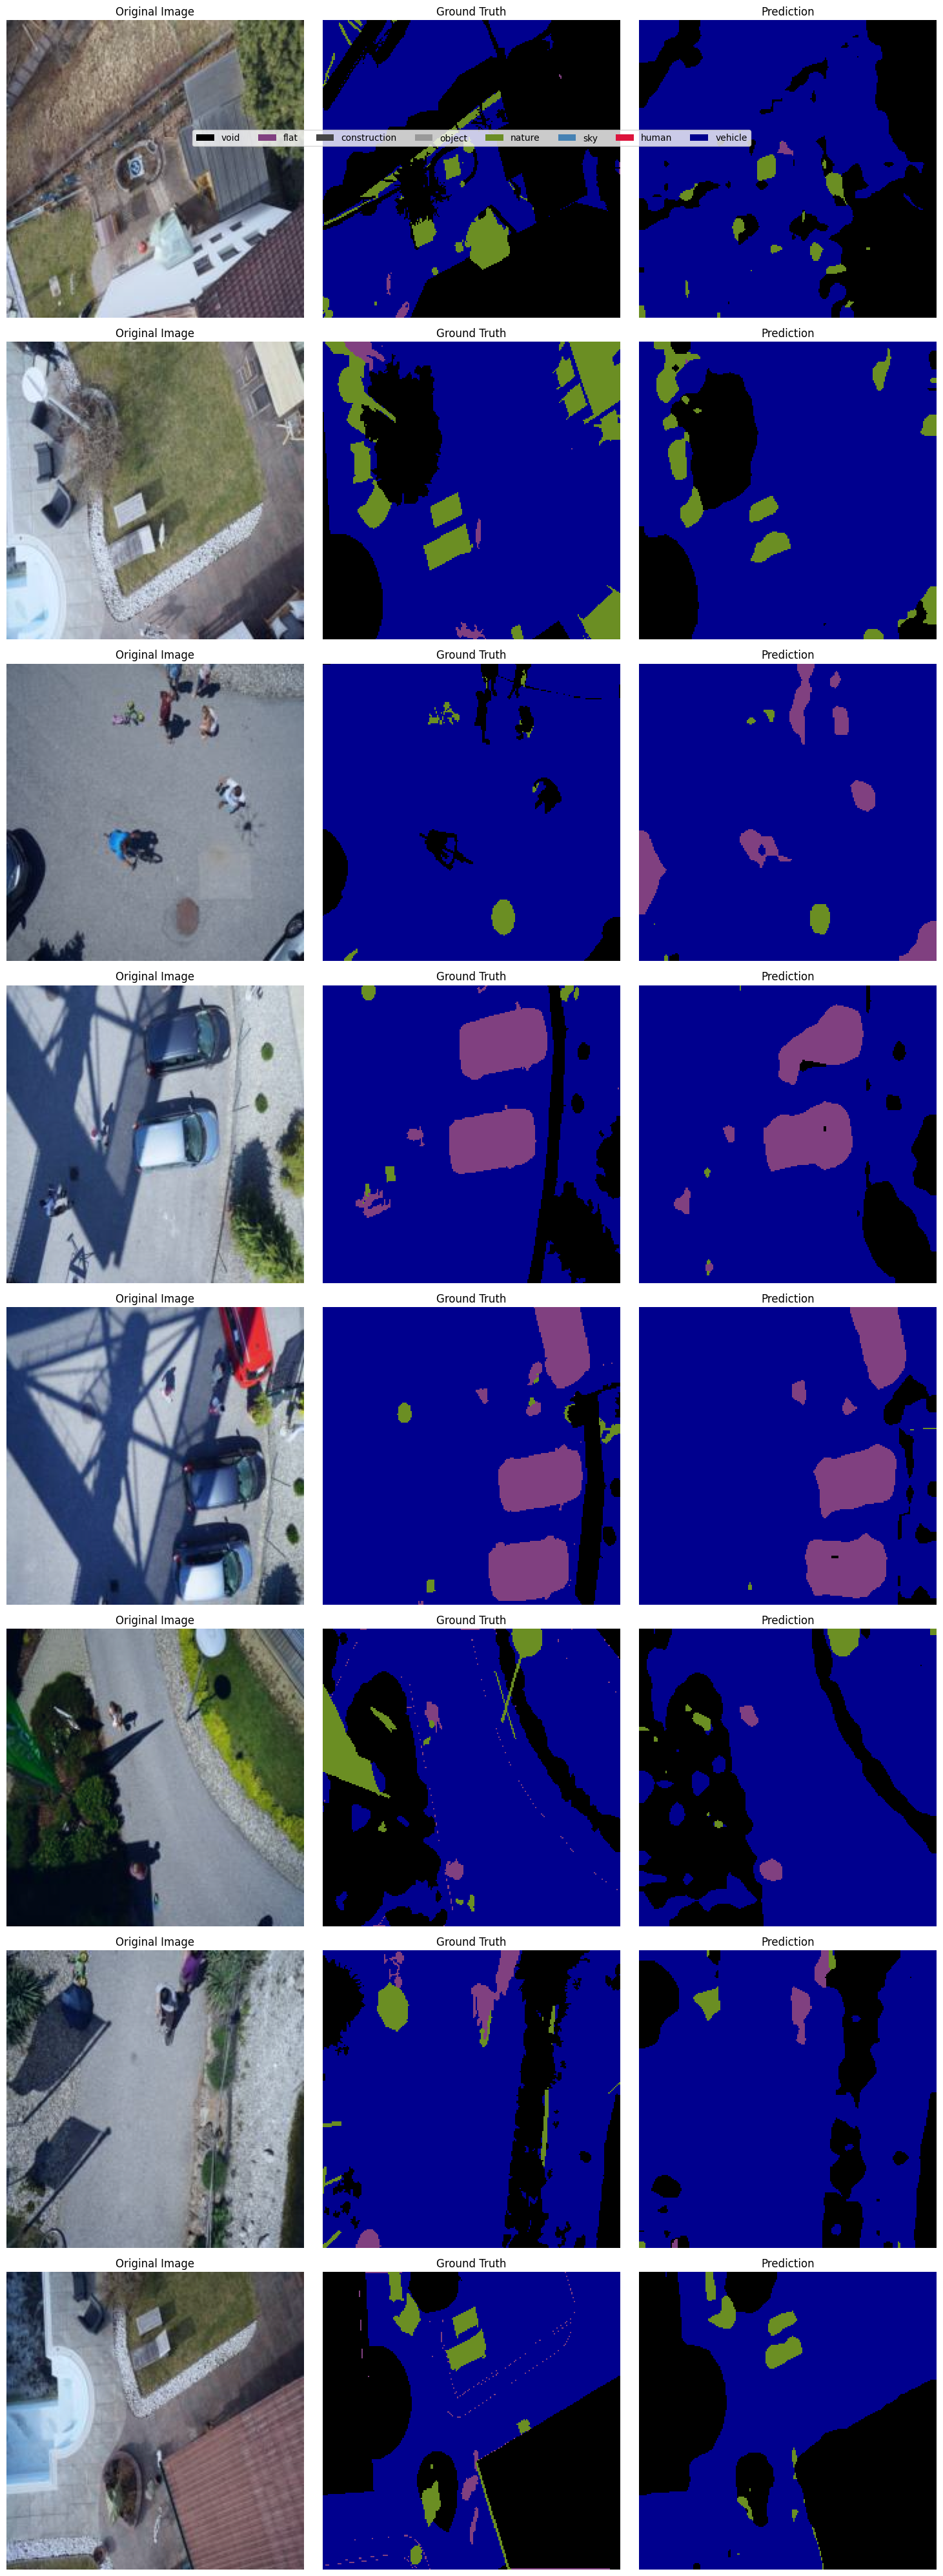

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import torch
import random


def visualize_batch(images, labels, preds, class_colors, class_names=None):
    """
    Visualizes a batch of original images, target masks, and predicted masks.

    Args:
        images: Tensor of shape (batch_size, channels, height, width)
        labels: Tensor of shape (batch_size, height, width)
        preds: Tensor of shape (batch_size, height, width)
        class_colors: List of RGB tuples for each class.
        class_names: Optional list of class names for a legend.
    """
    batch_size = images.shape[0]

    # Create a color map for segmentation masks
    cmap = ListedColormap(np.array(class_colors) / 255.0)  # Normalize colors to [0, 1]

    # Create a grid of subplots: each row for one sample (original, ground truth, prediction)
    fig, axes = plt.subplots(batch_size, 3, figsize=(15, 5 * batch_size))

    # If batch size is 1, adjust axes to avoid indexing issues
    if batch_size == 1:
        axes = axes[np.newaxis, :]

    for i in range(batch_size):
        # Convert image to numpy and normalize to [0, 1]
        img = images[i].permute(1, 2, 0).cpu().numpy()  # (height, width, channels)
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization

        # Convert labels and predictions to numpy arrays
        label = labels[i].cpu().numpy()
        pred = preds[i].cpu().numpy()

        # Remap labels and predictions to coarse categories
        label_coarse = np.vectorize(coarse_labels.get)(label)
        pred_coarse = np.vectorize(coarse_labels.get)(pred)

        # Plot the original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        # Plot the ground truth with the colormap
        axes[i, 1].imshow(label_coarse, cmap=cmap, interpolation="nearest")
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        # Plot the predictions with the colormap
        axes[i, 2].imshow(pred_coarse, cmap=cmap, interpolation="nearest")
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis("off")

    # Add a legend for class names if provided
    if class_names is not None:
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=np.array(color) / 255.0, label=name)
            for color, name in zip(class_colors, class_names)
        ]
        fig.legend(
            handles=legend_elements,
            loc="upper center",
            ncol=len(class_names),
            bbox_to_anchor=(0.5, 0.95),
        )

    plt.tight_layout()
    plt.show()


# Coarse labels mapping
coarse_labels = {
    1: 0, 2: 0, 3: 0, 4: 0,  # Grouped as 'Surfaces'
    5: 1, 7: 1,              # Grouped as 'Water and Pool'
    9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2,  # Grouped as 'Structures'
    8: 3, 19: 3, 20: 3,      # Grouped as 'Vegetation'
    6: 4,                    # 'Natural Elements'
    15: 5, 16: 5, 17: 5, 18: 5,  # 'Moving Objects'
    21: 6, 22: 6, 23: 6,     # 'Markers and Obstacles'
    0: 7,                    # 'Unlabeled'
}

# Define the specified class colors
class_colors = [
    (0, 0, 0),         # void: Black
    (128, 64, 128),    # flat (road, sidewalk): Purple
    (70, 70, 70),      # construction (building, wall): Dark gray
    (153, 153, 153),   # object (poles, signs): Light gray
    (107, 142, 35),    # nature (trees, vegetation): Green
    (70, 130, 180),    # sky: Light blue
    (220, 20, 60),     # human (pedestrians, cyclists): Red
    (0, 0, 142)        # vehicle: Dark blue
]

# Define consistent class names
class_names = [
    "void",
    "flat",
    "construction",
    "object",
    "nature",
    "sky",
    "human",
    "vehicle",
]

# Updated loop for random batch visualization
val_loader_batches = list(val_loader)  # Convert the loader to a list of batches
random_batch = random.choice(val_loader_batches)  # Randomly select one batch

images, labels = random_batch
images = images.to(device)  # Shape: (batch_size, channels, height, width)
labels = labels.to(device)  # Shape: (batch_size, height, width)

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(images)[0]  # Outputs shape: (batch_size, num_classes, height, width)
    preds = torch.argmax(outputs, dim=1)  # Convert logits to class indices

# Visualize the random batch with consistent class colors
visualize_batch(images, labels, preds, class_colors, class_names)


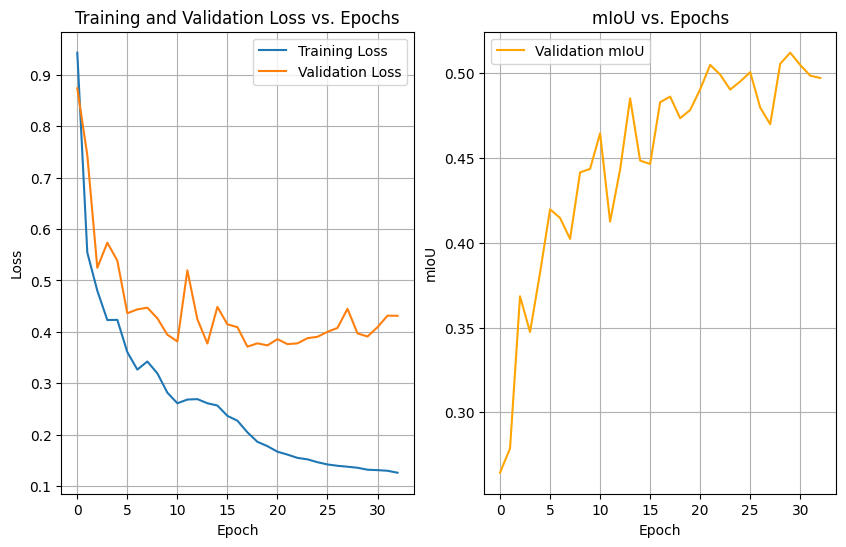

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot Training and Validation Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)

# Plot mIoU vs. Epochs
plt.subplot(1,2,2)
plt.plot(miou_scores, label='Validation mIoU', color='orange')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('mIoU vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


It seems the model may be overfitting, some data augmentation will be applied to ensure that the modelling is learning the general features of the images as opposed to overfitting on the training data


In [ ]:
"""
Data Augmentation ideas:

Flip
Add flips (horizontal and vertical to the training data)
Rotate
Add Rotations (45 deg, 70 deg, 100 deg rotated versions of the original images)

"""